# Data Preprocessing

In [216]:
import pandas as pd
#read data
Eads_df = pd.read_csv('./data/adsorption_energy.csv',index_col=0)

#Modify Column names for convinience
tasks = [col.split('(')[0].replace(' ','') for col in Eads_df.columns.to_list()]
Eads_df = Eads_df.set_axis(tasks, axis=1)
Eads_df = Eads_df.reset_index()

#Add Substrate and Dopant columns to each row
Eads_df['Substrate'] = Eads_df['name'].apply(lambda x: x.split('_')[0])
Eads_df['Dopant'] = Eads_df['name'].apply(lambda x: x.split('_')[1])

#Save substrates and dopants to a list
substrate_list = Eads_df['Substrate'].drop_duplicates().to_list()
dopant_list = Eads_df['Dopant'].drop_duplicates().to_list()

#Get Target for Training
target = Eads_df[tasks]

In [217]:
#Eads_df
print(f'There are total {len(substrate_list) * len(dopant_list)} pairs of binary catalysts,\nconsisted of {len(substrate_list)} substrates and {len(dopant_list)} dopants\n')
print(f'Substrates: {substrate_list}')
print(f'Dopants: {dopant_list}')

There are total 78 pairs of binary catalysts,
consisted of 6 substrates and 13 dopants

Substrates: ['Ag', 'Au', 'Cu', 'Ni', 'Pt', 'Co']
Dopants: ['Co', 'Cr', 'Fe', 'Ir', 'Mn', 'Mo', 'Os', 'Re', 'Ru', 'Ta', 'Tc', 'V', 'W']


In [258]:
#analyze Adsorption Energies for Further Use
from prettytable import PrettyTable

E_table = PrettyTable([''] + tasks)
E_table.title = 'mean and standard deivation values of adsorption energies'
E_table.add_row(['mean',f'{target["E_O"].mean():.3f}',f'{target["E_H"].mean():.3f}',f'{target["E_CO2"].mean():.3f}',f'{target["E_CO2"].mean():.3f}'])
E_table.add_row(['std',f'{target["E_O"].std():.3f}',f'{target["E_H"].std():.3f}',f'{target["E_CO2"].std():.3f}',f'{target["E_CO2"].std():.3f}'])
E_table

,E_O,E_H,E_CO2,E_CO
mean,0.035,-0.237,-0.209,-0.209
std,1.094,0.706,0.394,0.394


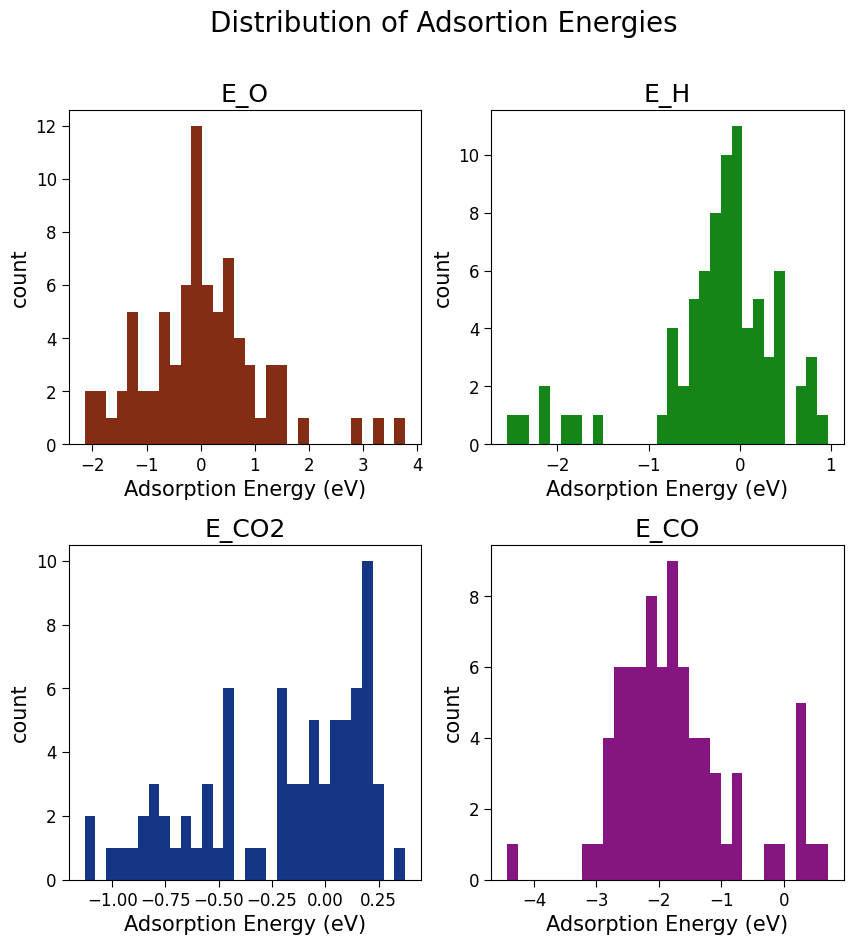

In [259]:
import matplotlib.pyplot as plt

colors = ['#852C15', '#158517','#153585','#851581']
fig, axs = plt.subplots(2,2,figsize=(10,10))
fig.suptitle('Distribution of Adsortion Energies', fontsize=20)
for i, ax in enumerate(axs.flatten()):
    ax.hist(target[tasks[i]],color=colors[i],bins=30)
    ax.set_title(tasks[i],fontsize=18)
    ax.set_xlabel('Adsorption Energy (eV)',fontsize=15)
    ax.set_ylabel('count',fontsize=15)
    ax.tick_params(axis='both',labelsize=12,length = 5)
fig.subplots_adjust(hspace=0.3,)

# Featurization

In [154]:
from mp_api.client import MPRester
API_KEY = "f87a4pCcUJ5wDNzvsdirVSByQscvc6ZF"
mpr = MPRester(API_KEY,use_document_model=False)

/Users/yujinkang/anaconda3/envs/laiddmg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [186]:
#Add properties of each substrate and dopant for featurization
sub_df = mpr.materials.summary.search(formula = substrate_list, num_elements =(1),fields=['formula_pretty','material_id','energy_above_hull','is_metal','is_stable','structure','symmetry'])
sub_df = pd.DataFrame(sub_df)
sub_df = sub_df[sub_df['is_stable']]
if sub_df['energy_above_hull'].all() == 0:
    sub_df = sub_df.drop(['is_stable','energy_above_hull','structure','symmetry','is_metal'],axis=1)
else:
    print('Unstable Metal Present')

if len(sub_df) == len(substrate_list):
    print(f'\nfound all {len(sub_df)} substrates from material projects')
elif len(sub_df) < len(substrate_list):
    print("didn't get all substrates")
else:
    print('more substrates than expected')
sub_df.head(3)

Retrieving SummaryDoc documents: 100%|██████████| 34/34 [00:00<00:00, 770845.06it/s]


found all 6 substrates from material projects


,formula_pretty,material_id
3,Au,mp-81
4,Ag,mp-8566
12,Ni,mp-23


In [187]:
#Add properties of each substrate and dopant for featurization
dop_df = mpr.materials.summary.search(formula = dopant_list, num_elements =(1),fields=['formula_pretty','material_id','energy_above_hull','is_metal','is_stable','structure','symmetry'])
dop_df = pd.DataFrame(dop_df)
dop_df = dop_df[dop_df['is_stable']]
if dop_df['energy_above_hull'].all() == 0:
    dop_df = dop_df.drop(['is_stable','energy_above_hull','structure','symmetry','is_metal'],axis=1)
else:
    print('Unstable Metal Present')

if len(dop_df) == len(dopant_list):
    print(f'\nfound all {len(dop_df)} dopants from material projects')
elif len(dop_df) < len(dopant_list):
    print("didn't get all dopants")
else:
    print('more dopants than expected')
dop_df.head(3)

Retrieving SummaryDoc documents: 100%|██████████| 79/79 [00:00<00:00, 790811.49it/s]


found all 13 dopants from material projects


,formula_pretty,material_id
3,Os,mp-49
5,Re,mp-1186901
10,Ru,mp-33


In [188]:
#featurization

from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.composition.element import TMetalFraction, BandCenter
from matminer.featurizers.composition.orbital import ValenceOrbital
from matminer.featurizers.composition.ion import ElectronAffinity

In [194]:
# use featurizers from the paper
element_property_featurizer = ElementProperty.from_preset(preset_name="magpie")
tm_featurizer = TMetalFraction()
bc_featurizer = BandCenter()
vo_featurizer = ValenceOrbital()

In [197]:
cnvrt_sub_df = StrToComposition().featurize_dataframe(sub_df, 'formula_pretty')
cnvrt_sub_df = element_property_featurizer.featurize_dataframe(cnvrt_sub_df, col_id="composition", ignore_errors=True)
cnvrt_sub_df = tm_featurizer.featurize_dataframe(cnvrt_sub_df, col_id="composition", ignore_errors=True)
cnvrt_sub_df = bc_featurizer.featurize_dataframe(cnvrt_sub_df, col_id="composition", ignore_errors=True)
cnvrt_sub_df = vo_featurizer.featurize_dataframe(cnvrt_sub_df, col_id="composition", ignore_errors=True)
cnvrt_sub_df.head()

ValenceOrbital: 100%|██████████| 6/6 [00:00<00:00, 108.45it/s]


,formula_pretty,material_id,composition,...,frac p valence electrons,frac d valence electrons,frac f valence electrons
3,Au,mp-81,(Au),...,0.0,0.400000,0.560000
4,Ag,mp-8566,(Ag),...,0.0,0.909091,0.000000
12,Ni,mp-23,(Ni),...,0.0,0.800000,0.000000
15,Cu,mp-30,(Cu),...,0.0,0.909091,0.000000
24,Pt,mp-126,(Pt),...,0.0,0.375000,0.583333


In [198]:
cnvrt_dop_df = StrToComposition().featurize_dataframe(dop_df, 'formula_pretty')
cnvrt_dop_df = element_property_featurizer.featurize_dataframe(cnvrt_dop_df, col_id="composition", ignore_errors=True)
cnvrt_dop_df = tm_featurizer.featurize_dataframe(cnvrt_dop_df, col_id="composition", ignore_errors=True)
cnvrt_dop_df = bc_featurizer.featurize_dataframe(cnvrt_dop_df, col_id="composition", ignore_errors=True)
cnvrt_dop_df = vo_featurizer.featurize_dataframe(cnvrt_dop_df, col_id="composition", ignore_errors=True)
cnvrt_dop_df.head()

ValenceOrbital: 100%|██████████| 13/13 [00:00<00:00, 175.16it/s]


,formula_pretty,material_id,composition,...,frac p valence electrons,frac d valence electrons,frac f valence electrons
3,Os,mp-49,(Os),...,0.0,0.272727,0.636364
5,Re,mp-1186901,(Re),...,0.0,0.238095,0.666667
10,Ru,mp-33,(Ru),...,0.0,0.875000,0.000000
19,Ta,mp-569794,(Ta),...,0.0,0.157895,0.736842
22,Tc,mp-113,(Tc),...,0.0,0.714286,0.000000


In [260]:
# save featurized dopants 
cnvrt_sub_df.to_csv('./data/substrate_df.csv')
cnvrt_dop_df.to_csv('./data/dopant_df.csv')

# Prepare input

In [374]:
# make feature dataframe of corresponding substrates
sub_df_feat = pd.DataFrame(columns = ['sub_'+col for col in cnvrt_sub_df.columns])
cnvrt_sub_df = cnvrt_sub_df.set_axis(cnvrt_sub_df['formula_pretty'],axis=0)
for i, s in enumerate(Eads_df['Substrate']):
    sub_df_feat.loc[i] = cnvrt_sub_df.loc[s].to_list()
sub_df_feat

,sub_formula_pretty,sub_material_id,sub_composition,sub_MagpieData minimum Number,sub_MagpieData maximum Number,sub_MagpieData range Number,sub_MagpieData mean Number,sub_MagpieData avg_dev Number,sub_MagpieData mode Number,sub_MagpieData minimum MendeleevNumber,sub_MagpieData maximum MendeleevNumber,sub_MagpieData range MendeleevNumber,sub_MagpieData mean MendeleevNumber,sub_MagpieData avg_dev MendeleevNumber,sub_MagpieData mode MendeleevNumber,...,sub_MagpieData maximum SpaceGroupNumber,sub_MagpieData range SpaceGroupNumber,sub_MagpieData mean SpaceGroupNumber,sub_MagpieData avg_dev SpaceGroupNumber,sub_MagpieData mode SpaceGroupNumber,sub_transition metal fraction,sub_band center,sub_avg s valence electrons,sub_avg p valence electrons,sub_avg d valence electrons,sub_avg f valence electrons,sub_frac s valence electrons,sub_frac p valence electrons,sub_frac d valence electrons,sub_frac f valence electrons
0,Ag,mp-8566,(Ag),47.0,47.0,0.0,47.0,0.0,47.0,65.0,65.0,0.0,65.0,0.0,65.0,...,225.0,0.0,225.0,0.0,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0
1,Ag,mp-8566,(Ag),47.0,47.0,0.0,47.0,0.0,47.0,65.0,65.0,0.0,65.0,0.0,65.0,...,225.0,0.0,225.0,0.0,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0
2,Ag,mp-8566,(Ag),47.0,47.0,0.0,47.0,0.0,47.0,65.0,65.0,0.0,65.0,0.0,65.0,...,225.0,0.0,225.0,0.0,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0
3,Ag,mp-8566,(Ag),47.0,47.0,0.0,47.0,0.0,47.0,65.0,65.0,0.0,65.0,0.0,65.0,...,225.0,0.0,225.0,0.0,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0
4,Ag,mp-8566,(Ag),47.0,47.0,0.0,47.0,0.0,47.0,65.0,65.0,0.0,65.0,0.0,65.0,...,225.0,0.0,225.0,0.0,225.0,1.0,4.439262,1.0,0.0,10.0,0.0,0.090909,0.0,0.909091,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Co,mp-102,(Co),27.0,27.0,0.0,27.0,0.0,27.0,58.0,58.0,0.0,58.0,0.0,58.0,...,194.0,0.0,194.0,0.0,194.0,1.0,4.270833,2.0,0.0,7.0,0.0,0.222222,0.0,0.777778,0.0
74,Co,mp-102,(Co),27.0,27.0,0.0,27.0,0.0,27.0,58.0,58.0,0.0,58.0,0.0,58.0,...,194.0,0.0,194.0,0.0,194.0,1.0,4.270833,2.0,0.0,7.0,0.0,0.222222,0.0,0.777778,0.0
75,Co,mp-102,(Co),27.0,27.0,0.0,27.0,0.0,27.0,58.0,58.0,0.0,58.0,0.0,58.0,...,194.0,0.0,194.0,0.0,194.0,1.0,4.270833,2.0,0.0,7.0,0.0,0.222222,0.0,0.777778,0.0
76,Co,mp-102,(Co),27.0,27.0,0.0,27.0,0.0,27.0,58.0,58.0,0.0,58.0,0.0,58.0,...,194.0,0.0,194.0,0.0,194.0,1.0,4.270833,2.0,0.0,7.0,0.0,0.222222,0.0,0.777778,0.0


In [373]:
# make feature dataframe of corresponding dopants
dop_df_feat = pd.DataFrame(columns = ['dop_'+col for col in cnvrt_dop_df.columns])
cnvrt_dop_df = cnvrt_dop_df.set_axis(cnvrt_dop_df['formula_pretty'],axis=0)
for i, s in enumerate(Eads_df['Dopant']):
    dop_df_feat.loc[i] = cnvrt_dop_df.loc[s].to_list()
dop_df_feat

,dop_formula_pretty,dop_material_id,dop_composition,dop_MagpieData minimum Number,dop_MagpieData maximum Number,dop_MagpieData range Number,dop_MagpieData mean Number,dop_MagpieData avg_dev Number,dop_MagpieData mode Number,dop_MagpieData minimum MendeleevNumber,dop_MagpieData maximum MendeleevNumber,dop_MagpieData range MendeleevNumber,dop_MagpieData mean MendeleevNumber,dop_MagpieData avg_dev MendeleevNumber,dop_MagpieData mode MendeleevNumber,...,dop_MagpieData maximum SpaceGroupNumber,dop_MagpieData range SpaceGroupNumber,dop_MagpieData mean SpaceGroupNumber,dop_MagpieData avg_dev SpaceGroupNumber,dop_MagpieData mode SpaceGroupNumber,dop_transition metal fraction,dop_band center,dop_avg s valence electrons,dop_avg p valence electrons,dop_avg d valence electrons,dop_avg f valence electrons,dop_frac s valence electrons,dop_frac p valence electrons,dop_frac d valence electrons,dop_frac f valence electrons
0,Co,mp-102,(Co),27.0,27.0,0.0,27.0,0.0,27.0,58.0,58.0,0.0,58.0,0.0,58.0,...,194.0,0.0,194.0,0.0,194.0,1.0,4.270833,2.0,0.0,7.0,0.0,0.222222,0.0,0.777778,0.000000
1,Cr,mp-90,(Cr),24.0,24.0,0.0,24.0,0.0,24.0,49.0,49.0,0.0,49.0,0.0,49.0,...,229.0,0.0,229.0,0.0,229.0,1.0,3.716833,1.0,0.0,5.0,0.0,0.166667,0.0,0.833333,0.000000
2,Fe,mp-13,(Fe),26.0,26.0,0.0,26.0,0.0,26.0,55.0,55.0,0.0,55.0,0.0,55.0,...,229.0,0.0,229.0,0.0,229.0,1.0,4.032960,2.0,0.0,6.0,0.0,0.250000,0.0,0.750000,0.000000
3,Ir,mp-101,(Ir),77.0,77.0,0.0,77.0,0.0,77.0,60.0,60.0,0.0,60.0,0.0,60.0,...,225.0,0.0,225.0,0.0,225.0,1.0,5.343076,2.0,0.0,7.0,14.0,0.086957,0.0,0.304348,0.608696
4,Mn,mp-35,(Mn),25.0,25.0,0.0,25.0,0.0,25.0,52.0,52.0,0.0,52.0,0.0,52.0,...,217.0,0.0,217.0,0.0,217.0,1.0,3.717351,2.0,0.0,5.0,0.0,0.285714,0.0,0.714286,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Ru,mp-33,(Ru),44.0,44.0,0.0,44.0,0.0,44.0,56.0,56.0,0.0,56.0,0.0,56.0,...,194.0,0.0,194.0,0.0,194.0,1.0,4.205535,1.0,0.0,7.0,0.0,0.125000,0.0,0.875000,0.000000
74,Ta,mp-569794,(Ta),73.0,73.0,0.0,73.0,0.0,73.0,48.0,48.0,0.0,48.0,0.0,48.0,...,229.0,0.0,229.0,0.0,229.0,1.0,4.104478,2.0,0.0,3.0,14.0,0.105263,0.0,0.157895,0.736842
75,Tc,mp-113,(Tc),43.0,43.0,0.0,43.0,0.0,43.0,53.0,53.0,0.0,53.0,0.0,53.0,...,194.0,0.0,194.0,0.0,194.0,1.0,3.912728,2.0,0.0,5.0,0.0,0.285714,0.0,0.714286,0.000000
76,V,mp-146,(V),23.0,23.0,0.0,23.0,0.0,23.0,46.0,46.0,0.0,46.0,0.0,46.0,...,229.0,0.0,229.0,0.0,229.0,1.0,3.635468,2.0,0.0,3.0,0.0,0.400000,0.0,0.600000,0.000000


In [404]:
# concat dataframes and create input df
feat_concat = pd.concat([sub_df_feat, dop_df_feat],axis=1)
input_df = pd.concat([Eads_df, feat_concat],axis=1)

In [405]:
#save df
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 400)
input_df.to_csv('./data/featurized_input_df.csv')
input_df

,name,E_O,E_H,E_CO2,E_CO,Substrate,Dopant,sub_formula_pretty,sub_material_id,sub_composition,sub_MagpieData minimum Number,sub_MagpieData maximum Number,sub_MagpieData range Number,sub_MagpieData mean Number,sub_MagpieData avg_dev Number,sub_MagpieData mode Number,sub_MagpieData minimum MendeleevNumber,sub_MagpieData maximum MendeleevNumber,sub_MagpieData range MendeleevNumber,sub_MagpieData mean MendeleevNumber,sub_MagpieData avg_dev MendeleevNumber,sub_MagpieData mode MendeleevNumber,sub_MagpieData minimum AtomicWeight,sub_MagpieData maximum AtomicWeight,sub_MagpieData range AtomicWeight,sub_MagpieData mean AtomicWeight,sub_MagpieData avg_dev AtomicWeight,sub_MagpieData mode AtomicWeight,sub_MagpieData minimum MeltingT,sub_MagpieData maximum MeltingT,sub_MagpieData range MeltingT,sub_MagpieData mean MeltingT,sub_MagpieData avg_dev MeltingT,sub_MagpieData mode MeltingT,sub_MagpieData minimum Column,sub_MagpieData maximum Column,sub_MagpieData range Column,sub_MagpieData mean Column,sub_MagpieData avg_dev Column,sub_MagpieData mode Column,sub_MagpieData minimum Row,sub_MagpieData maximum Row,sub_MagpieData range Row,sub_MagpieData mean Row,sub_MagpieData avg_dev Row,sub_MagpieData mode Row,sub_MagpieData minimum CovalentRadius,sub_MagpieData maximum CovalentRadius,sub_MagpieData range CovalentRadius,sub_MagpieData mean CovalentRadius,sub_MagpieData avg_dev CovalentRadius,sub_MagpieData mode CovalentRadius,sub_MagpieData minimum Electronegativity,sub_MagpieData maximum Electronegativity,sub_MagpieData range Electronegativity,sub_MagpieData mean Electronegativity,sub_MagpieData avg_dev Electronegativity,sub_MagpieData mode Electronegativity,sub_MagpieData minimum NsValence,sub_MagpieData maximum NsValence,sub_MagpieData range NsValence,sub_MagpieData mean NsValence,sub_MagpieData avg_dev NsValence,sub_MagpieData mode NsValence,sub_MagpieData minimum NpValence,sub_MagpieData maximum NpValence,sub_MagpieData range NpValence,sub_MagpieData mean NpValence,sub_MagpieData avg_dev NpValence,sub_MagpieData mode NpValence,sub_MagpieData minimum NdValence,sub_MagpieData maximum NdValence,sub_MagpieData range NdValence,sub_MagpieData mean NdValence,sub_MagpieData avg_dev NdValence,sub_MagpieData mode NdValence,sub_MagpieData minimum NfValence,sub_MagpieData maximum NfValence,sub_MagpieData range NfValence,sub_MagpieData mean NfValence,sub_MagpieData avg_dev NfValence,sub_MagpieData mode NfValence,sub_MagpieData minimum NValence,sub_MagpieData maximum NValence,sub_MagpieData range NValence,sub_MagpieData mean NValence,sub_MagpieData avg_dev NValence,sub_MagpieData mode NValence,sub_MagpieData minimum NsUnfilled,sub_MagpieData maximum NsUnfilled,sub_MagpieData range NsUnfilled,sub_MagpieData mean NsUnfilled,sub_MagpieData avg_dev NsUnfilled,sub_MagpieData mode NsUnfilled,sub_MagpieData minimum NpUnfilled,sub_MagpieData maximum NpUnfilled,sub_MagpieData range NpUnfilled,sub_MagpieData mean NpUnfilled,sub_MagpieData avg_dev NpUnfilled,sub_MagpieData mode NpUnfilled,sub_MagpieData minimum NdUnfilled,sub_MagpieData maximum NdUnfilled,sub_MagpieData range NdUnfilled,sub_MagpieData mean NdUnfilled,sub_MagpieData avg_dev NdUnfilled,sub_MagpieData mode NdUnfilled,sub_MagpieData minimum NfUnfilled,sub_MagpieData maximum NfUnfilled,sub_MagpieData range NfUnfilled,sub_MagpieData mean NfUnfilled,sub_MagpieData avg_dev NfUnfilled,sub_MagpieData mode NfUnfilled,sub_MagpieData minimum NUnfilled,sub_MagpieData maximum NUnfilled,sub_MagpieData range NUnfilled,sub_MagpieData mean NUnfilled,sub_MagpieData avg_dev NUnfilled,sub_MagpieData mode NUnfilled,sub_MagpieData minimum GSvolume_pa,sub_MagpieData maximum GSvolume_pa,sub_MagpieData range GSvolume_pa,sub_MagpieData mean GSvolume_pa,sub_MagpieData avg_dev GSvolume_pa,sub_MagpieData mode GSvolume_pa,sub_MagpieData minimum GSbandgap,sub_MagpieData maximum GSbandgap,sub_MagpieData range GSbandgap,sub_MagpieData mean GSbandgap,sub_MagpieData avg_dev GSbandgap,sub_MagpieData mode GSbandgap,sub_MagpieData minimum 

In [406]:
# drop non-feature values from input_df 
input_df_clean = input_df.drop(['E_O','E_H','E_CO','E_CO2','Substrate','Dopant','sub_formula_pretty','dop_formula_pretty','sub_composition','dop_composition','sub_material_id','dop_material_id'],axis=1)
input_df_clean.to_csv('./data/input_df_clean.csv')


In [408]:
input_df_clean

,name,sub_MagpieData minimum Number,sub_MagpieData maximum Number,sub_MagpieData range Number,...,dop_frac s valence electrons,dop_frac p valence electrons,dop_frac d valence electrons,dop_frac f valence electrons
0,Ag_Co,47.0,47.0,0.0,...,0.222222,0.0,0.777778,0.000000
1,Ag_Cr,47.0,47.0,0.0,...,0.166667,0.0,0.833333,0.000000
2,Ag_Fe,47.0,47.0,0.0,...,0.250000,0.0,0.750000,0.000000
3,Ag_Ir,47.0,47.0,0.0,...,0.086957,0.0,0.304348,0.608696
4,Ag_Mn,47.0,47.0,0.0,...,0.285714,0.0,0.714286,0.000000
...,...,...,...,...,...,...,...,...,...
73,Co_Ru,27.0,27.0,0.0,...,0.125000,0.0,0.875000,0.000000
74,Co_Ta,27.0,27.0,0.0,...,0.105263,0.0,0.157895,0.736842
75,Co_Tc,27.0,27.0,0.0,...,0.285714,0.0,0.714286,0.000000
76,Co_V,27.0,27.0,0.0,...,0.400000,0.0,0.600000,0.000000


In [409]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 9)
input_df_clean = input_df_clean.drop(['name'],axis=1)

In [410]:
input_df_clean

,sub_MagpieData minimum Number,sub_MagpieData maximum Number,sub_MagpieData range Number,sub_MagpieData mean Number,...,dop_frac s valence electrons,dop_frac p valence electrons,dop_frac d valence electrons,dop_frac f valence electrons
0,47.0,47.0,0.0,47.0,...,0.222222,0.0,0.777778,0.000000
1,47.0,47.0,0.0,47.0,...,0.166667,0.0,0.833333,0.000000
2,47.0,47.0,0.0,47.0,...,0.250000,0.0,0.750000,0.000000
3,47.0,47.0,0.0,47.0,...,0.086957,0.0,0.304348,0.608696
4,47.0,47.0,0.0,47.0,...,0.285714,0.0,0.714286,0.000000
...,...,...,...,...,...,...,...,...,...
73,27.0,27.0,0.0,27.0,...,0.125000,0.0,0.875000,0.000000
74,27.0,27.0,0.0,27.0,...,0.105263,0.0,0.157895,0.736842
75,27.0,27.0,0.0,27.0,...,0.285714,0.0,0.714286,0.000000
76,27.0,27.0,0.0,27.0,...,0.400000,0.0,0.600000,0.000000


In [471]:
# draw Pearson correlation plot
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 400)

#remove NaN
nan_cols = []
for c in input_df_clean.corr().columns:
    if len(input_df_clean.corr()[c].dropna()) == 0:
        nan_cols.append(c)


In [475]:
len(nan_cols)
input_df_clean2 = input_df_clean.drop(nan_cols, axis=1)

/Users/yujinkang/anaconda3/envs/laiddmg/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/yujinkang/anaconda3/envs/laiddmg/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


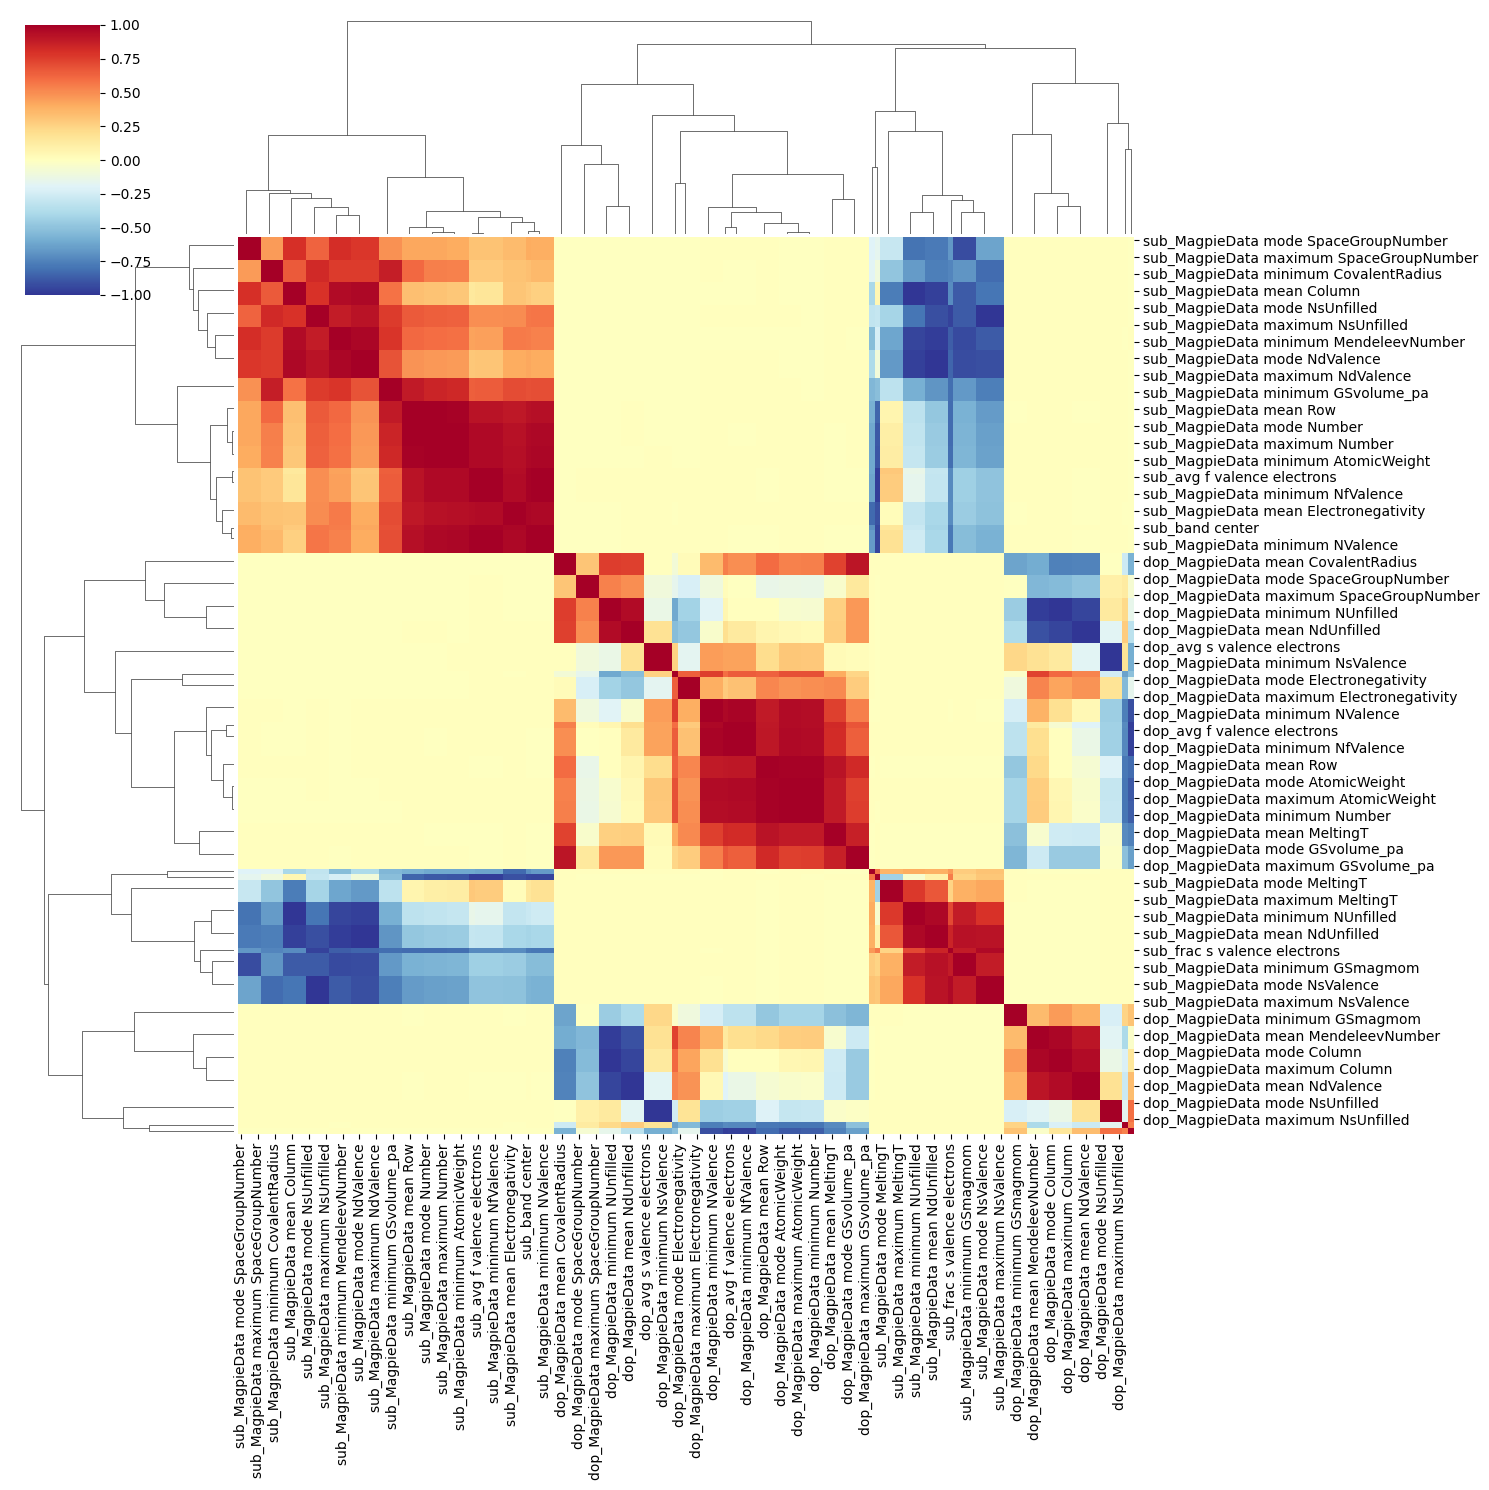

In [476]:
import seaborn as sns
sns.clustermap(input_df_clean2 .corr(),
               annot = False,      
               cmap = 'RdYlBu_r',  
               vmin = -1, vmax = 1,
               figsize=(15,15),
              );

In [477]:
input_df_clean2.to_csv('./data/input_df_clean2.csv')